<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/%EA%B8%B0%EB%A7%90%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/LSTM_sentiment_analysis_kor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -v python-mecab-ko

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.9/573.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 22.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!pip install pandas openpyxl


In [5]:
import pandas as pd

file_path = '/content/drive/MyDrive/삼성전자.xlsx'
df = pd.read_excel(file_path)

# 데이터 확인
print(df.head())


   labels                            Description 
0      -2         삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1       1  글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가
2      -1         중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3       2      삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델
4       1  4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상


In [6]:
print('총 샘플의 수:', len(df))


총 샘플의 수: 110


In [7]:
df

,labels,Description
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가"
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델"
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상"
...,...,...
105,1,TSMC는 아이폰15·PC용 반도체 주문이 몰리며 실적 증가
106,-1,삼성전자는 중저가 5세대 AP 시스템온칩과 OLED DDI 주문 증가
107,0,세계 파운드리 시장 점유율 순위에서 삼성전자는 2위
108,-1,TSMC의 최첨단 3나노 제품이 매출의 6%를 차지


In [8]:
df['labels'] = df['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
df[:5]

,labels,Description
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가"
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델"
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상"


In [9]:
df[:5]

,labels,Description
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가"
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델"
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        110 non-null    int64 
 1   Description   110 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [11]:
print('결측값 여부 :',df.isnull().values.any())

결측값 여부 : False


In [13]:
print('Description 열의 유니크한 값 :', df['Description '].nunique())

Description 열의 유니크한 값 : 110


In [14]:
duplicate = df[df.duplicated()]
duplicate

,labels,Description


<Axes: >

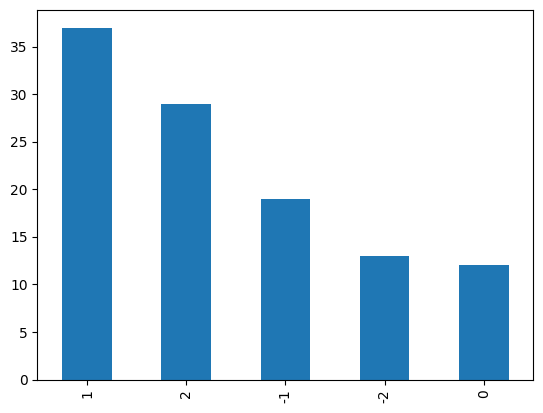

In [16]:
df['labels'].value_counts().plot(kind='bar')

In [17]:
print('레이블의 분포')
print(df.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0      -2     13
1      -1     19
2       0     12
3       1     37
4       2     29


In [21]:
print(f'중립의 비율 = {round(df["labels"].value_counts()[0]/len(df) * 100,3)}%')
print(f'긍정의 비율 = {round(df["labels"].value_counts()[1]/len(df) * 100,3)}%')
print(f'부정의 비율 = {round(df["labels"].value_counts()[2]/len(df) * 100,3)}%')

중립의 비율 = 10.909%
긍정의 비율 = 33.636%
부정의 비율 = 26.364%


In [58]:
from konlpy.tag import Okt
okt = Okt()
df['tokenized'] = df['Description '].apply(okt.morphs)


In [59]:
df

,labels,Description,tokenized
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락,"[삼성, 전자, 폴, 더블, 폰, 시장, 점유, 율, 이, 86%, 에서, 72%,..."
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가","[글로벌, 폴, 더블, 폰, 시장, 이, 전, 년, 대비, 16%, ,, 전, 분기..."
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락,"[중국, 업체, 들, 의, 공격, 적, 인, 제품, 출시, 로, 삼성, 전자, 점유..."
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델","[삼성, 갤럭시, Z, 플립, 5, 와, 폴드, 5, ,, 시장, 에서, 가장, 잘..."
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상","[4분, 기, 삼성, 전자, 폴, 더블, 폰, 점유, 율, ,, 작년, 83%, 에..."
...,...,...,...
105,1,TSMC는 아이폰15·PC용 반도체 주문이 몰리며 실적 증가,"[TSMC, 는, 아이폰, 15, ·, PC, 용, 반도체, 주문, 이, 몰리, 며..."
106,-1,삼성전자는 중저가 5세대 AP 시스템온칩과 OLED DDI 주문 증가,"[삼, 성, 전자, 는, 중, 저가, 5, 세대, AP, 시스템, 온, 칩, 과, ..."
107,0,세계 파운드리 시장 점유율 순위에서 삼성전자는 2위,"[세계, 파운드리, 시장, 점유, 율, 순위, 에서, 삼, 성, 전자, 는, 2, 위]"
108,-1,TSMC의 최첨단 3나노 제품이 매출의 6%를 차지,"[TSMC, 의, 최첨단, 3, 나노, 제품, 이, 매출, 의, 6%, 를, 차지]"


In [60]:
X_data = df['tokenized']
y_data = df['labels']
print('본문의 개수: {}'.format(len(X_df)))
print('레이블의 개수: {}'.format(len(y_df)))


본문의 개수: 110
레이블의 개수: 110


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=0, stratify=y_df)

In [65]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 88
테스트 샘플의 개수 : 22


In [66]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')


--------훈련 데이터의 비율-----------
중립 = 11.364%
긍정 = 34.091%
부정 = 26.136%


In [67]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')


--------테스트 데이터의 비율-----------
중립 = 9.091%
긍정 = 31.818%
부정 = 27.273%


In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[3, 6, 30, 97, 98, 99, 100, 101, 51, 52], [102, 103, 104, 105, 106, 107, 108], [53, 31, 54, 109, 4, 32, 110, 2], [55, 111, 56, 33, 34, 24, 57, 112, 35], [113, 58, 59, 114, 115, 36, 116, 117]]
[[354, 87, 346, 20, 267, 20, 2], [168], [12, 4, 58], [1, 46], [1, 17]]


In [69]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

481


본문의 최대 길이 : 48
본문의 평균 길이 : 31.761363636363637


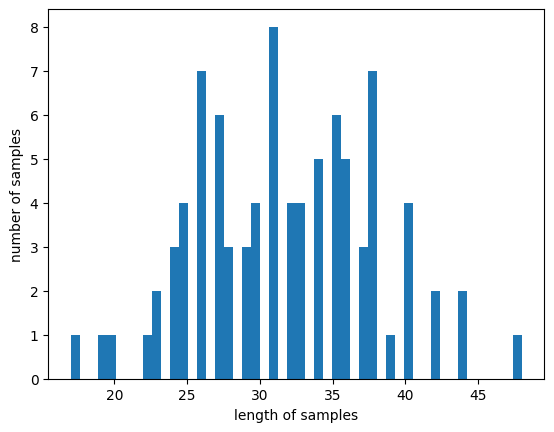

In [70]:
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [71]:
max_len = 76
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [72]:
X_train_encoded.shape

(88, 76)

In [73]:
X_test_encoded.shape

(22, 76)

In [74]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [75]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [76]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)


Epoch 1/15
3/3 [==============================] - ETA: 0s - loss: 1.0972 - acc: 0.4000
Epoch 1: val_acc improved from -inf to 0.44444, saving model to best_model.h5
3/3 [==============================] - 6s 1s/step - loss: 1.0972 - acc: 0.4000 - val_loss: 1.0802 - val_acc: 0.4444
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 1.0790 - acc: 0.6429
Epoch 2: val_acc improved from 0.44444 to 0.55556, saving model to best_model.h5
3/3 [==============================] - 0s 171ms/step - loss: 1.0790 - acc: 0.6429 - val_loss: 1.0645 - val_acc: 0.5556
Epoch 3/15
3/3 [==============================] - ETA: 0s - loss: 1.0642 - acc: 0.6857
Epoch 3: val_acc did not improve from 0.55556
3/3 [==============================] - 0s 100ms/step - loss: 1.0642 - acc: 0.6857 - val_loss: 1.0440 - val_acc: 0.3889
Epoch 4/15
3/3 [==============================] - ETA: 0s - loss: 1.0406 - acc: 0.8286
Epoch 4: val_acc did not improve from 0.55556
3/3 [==============================] - 0s 117ms/step - loss: 1.0406 - acc: 0.8286 - val_loss: 1.0149 - val_acc: 0.3889
Epoch 5/15
3/3 [==============================] - ETA: 0s - loss: 1.0088 - acc: 0.8000
Epoch 5: val_acc did not improve from 0.55556
3/3 [==============================] - 0s 178ms/step - loss: 1.0088 - acc: 0.8000 - val

In [78]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

1/1 [==============================] - 1s 531ms/step - loss: 0.9494 - acc: 0.4091

 테스트 정확도: 0.4091
